# Sinkhorn divergence gradient flows

In [ ]:

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from IPython import display

import ott
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.tools import plot, sinkhorn_divergence

## Defining two distributions

Let us start by defining simple source and target distributions.

In [ ]:
key1, key2 = jax.random.split(jax.random.PRNGKey(0), 2)

x = 0.25 * jax.random.normal(key1, (25, 2))  # Source
y = x #0.5 * jax.random.normal(key2, (50, 2)) + jnp.array((6, 0))  # Target

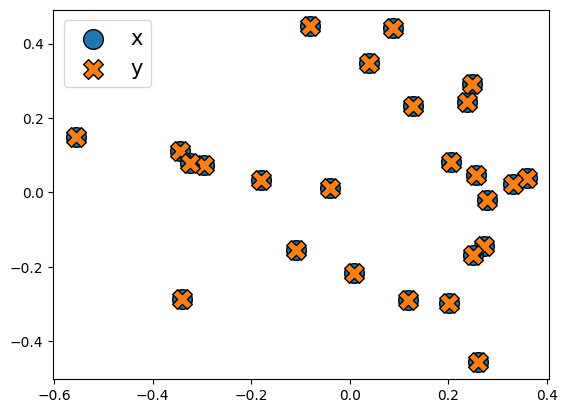

In [ ]:
plt.scatter(x[:, 0], x[:, 1], edgecolors="k", marker="o", label="x", s=200)
plt.scatter(y[:, 0], y[:, 1], edgecolors="k", marker="X", label="y", s=200)
plt.legend(fontsize=15)
plt.show()

## Gradient flow with $\mathrm{OT}_\varepsilon$

As in the {doc}`point_clouds` tutorial, we now compute the gradient flow for the regularized OT cost using the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm.

The code below performs gradient descent to move the points of $x$ in a way that minimizes the regularized OT cost.

In [ ]:
def sink_div(geom,a,b):
    """Return the Sinkhorn divergence cost and OT output given a geometry.
    Since y is fixed, we can use static_b=True to avoid computing
    the OT(b, b) term."""
    ot = sinkhorn_divergence.sinkhorn_divergence(
        geom,
        x=geom.x,
        a=a,
        b=b,
        y=geom.y,
        static_b=True,
    )
    return ot.divergence, ot

In [ ]:
def gradient_flow(
    x: jnp.ndarray,
    y: jnp.ndarray,
    a,
    b,
    cost_fn: callable,
    num_iter: int = 500,
    lr: float = 0.2,
    dump_every: int = 50,
    epsilon: float = 0.1,
):
    """Compute a gradient flow."""

    ots = []
    cost_fn_vg = jax.jit(jax.value_and_grad(cost_fn, has_aux=True, argnums=(0, 1)))
    for i in range(0, num_iter + 1):
        geom = pointcloud.PointCloud(x, y)
        (cost,ot), geom_g = cost_fn_vg(geom, a, b)
        assert ot.converged
        a = jax.nn.softmax(a - geom_g[1] * 0.2)
        #x = x - geom_g[0].x * lr  # Perform a gradient descent step.
        if i % dump_every == 0:
            ots.append(ot)  # Save the current state of the optimization.

    return ots

In [ ]:
def display_animation(ots, plot_class=plot.Plot):
    """Display an animation of the gradient flow."""
    plott = plot_class(show_lines=False)
    anim = plott.animate(ots, frame_rate=4)
    html = display.HTML(anim.to_jshtml())
    display.display(html)
    plt.close()

In [ ]:
def reg_ot_cost(geom, a, b):
    """Return the OT cost and OT output given a geometry"""
    ot = sinkhorn.Sinkhorn()(linear_problem.LinearProblem(geom,a=a, b=b))
    return ot.reg_ot_cost, ot

For the default value of $\varepsilon$, the gradient flow behaves as expected:

In [ ]:
geom = pointcloud.PointCloud(x, y)

marginal_a = jax.random.normal(key1, shape=(25, ))
marginal_b = jax.random.normal(key2, shape=(25, ))
marginal_a = jax.nn.softmax(marginal_a)
marginal_b = jax.nn.softmax(marginal_b)
# marginal_a /= jnp.sum(marginal_a)
# marginal_b /= jnp.sum(marginal_b)

[]

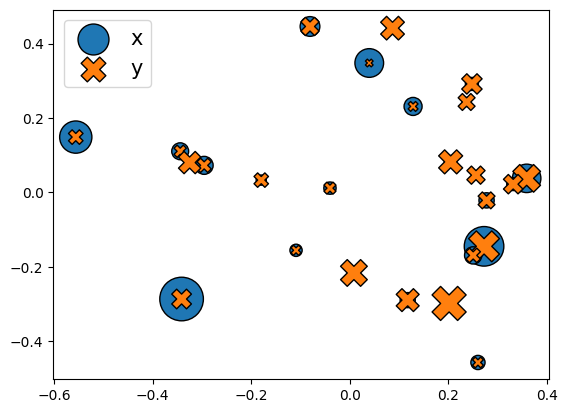

In [ ]:
class CustomPlot(plot.Plot):
    def _scatter(self, ot):
        x, y = ot.geoms[0].x, ot.geoms[0].y
        print(ot.a)
        a, b = ot.a, ot.b
        scales_x = a * self._scale * a.shape[0]
        scales_y = b * self._scale * b.shape[0]
        return x, y, scales_x, scales_y

cost, ot = reg_ot_cost(geom, marginal_a, marginal_b)
plot.Plot(show_lines=False)(ot)

In [ ]:
# Compute and display the gradient flow for the regularized OT cost.
ots = gradient_flow(x, y, a=marginal_a, b=marginal_b, cost_fn=sink_div)
display_animation(ots, CustomPlot)

[]

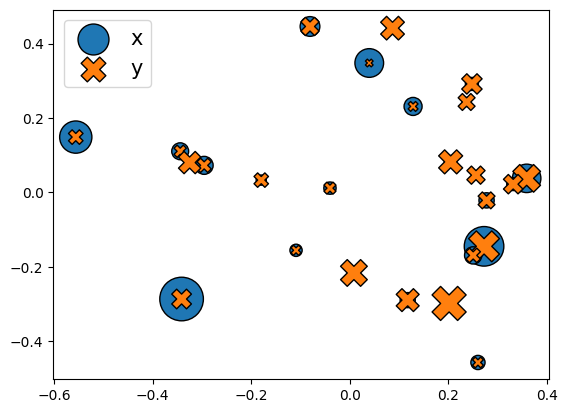

In [ ]:
cost, ot = reg_ot_cost(geom, ots[0].a, marginal_b)
plot.Plot(show_lines=False)(ot)

[]

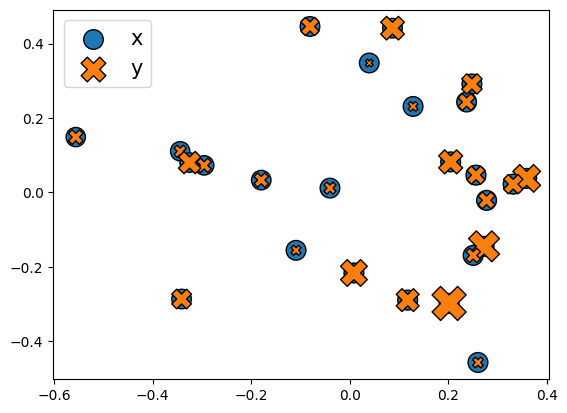

In [ ]:
cost, ot = reg_ot_cost(geom, ots[1].a, marginal_b)
plot.Plot(show_lines=False)(ot)